# Binary Classification
        
**Target의 class** : 0 (malignant(악성종양)) &  1 (benign(양성종양))

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Data Load & pre-processing

In [3]:
# data load
X, y = load_breast_cancer(return_X_y=True)

print(type(X), type(y))
print(X.shape, y.shape)
print(np.unique(y))       # 분류할 category는 '0' or '1'

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(569, 30) (569,)
[0 1]


In [4]:
# y.shape을 2차원으로 변경((569, ) -> (569,1)) ==> 모델 출력 shape과 맞춰준다.
# (batch_size, 1)
y = y.reshape(-1, 1)
y.shape

(569, 1)

In [5]:
# train set, test set을 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    stratify=y)       # class별 비율을 맞춰서 나눠준다
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(426, 30) (143, 30) (426, 1) (143, 1)


In [6]:
## pre-processing - feature scailing (column의 scale을 맞춘다)
## standardScaler ==> 평균: 0, 표준편차: 1을 기준으로 맞춤

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)        # trainset으로 fitting한 scaler를 이용해서 변환

In [7]:
# ndarray => tensor 변환 => dataset을 구성 => dataloader구성

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [8]:
# dataset 생성 ==> 메모리의 tensor를 dataset으로 생성 ==> TensorDataset
trainset = TensorDataset(X_train_tensor, y_train_tensor)
testset = TensorDataset(X_test_tensor, y_test_tensor)

# dataloader 생성 
train_loader = DataLoader(trainset, batch_size=200, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=len(testset))

# Model Class Define

In [9]:
class BCModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(30, 32)
        self.lr2 = nn.Linear(32, 8)
        self.lr3 = nn.Linear(8, 1)

    def forward(self, X):
        out = nn.ReLU()(self.lr1(X))
        out = nn.ReLU()(self.lr2(out))

        out = self.lr3(out)
        out = nn.Sigmoid()(out)
        return out

In [10]:
model = BCModel()
tmp_x = torch.ones(5, 30)
print(tmp_x.shape)

tmp_y = model(tmp_x)
tmp_y   # 1(양성-positive)일 확률!

torch.Size([5, 30])


tensor([[0.4360],
        [0.4360],
        [0.4360],
        [0.4360],
        [0.4360]], grad_fn=<SigmoidBackward0>)

In [ ]:
# tensor객체.type(타입을지정) ==> tensor data type 변환
## bool type -> int type : False(0), True(1)로 바뀐다
(tmp_y > 0.5).type(torch.int32)

# Training

In [13]:
import tqdm as notebook_tqdm

In [14]:
# hyper parameters define
LR = 0.001
N_EPOCH = 1000

model = BCModel().to(device)        # model define
loss_fn = nn.BCELoss()              # loss function - binary cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimizer

In [15]:
import time
train_loss_list, val_loss_list, val_accuracy_list = [], [], []

best_score = torch.inf                           # 'valid loss' save
save_bcmodel_path = 'models/bc_best_model.pth'   # 'best model' save

patience = 20          # 성능이 개선될 때까지 20epoch 기다리겠다.
trigger_cnt = 0        # 성능이 개선될 때까지 현재 몇 번째 기다렸는지. (성능이 개선될 때마다 0으로 초기화!)


sec_s = time.time()
for epoch in range(N_EPOCH):

    ### Train ###
    model.train()
    train_loss = 0.0

    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        pred = model(X_train)
        loss = loss_fn(pred, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    train_loss_list.append(train_loss / len(train_loader))

    
    ### Validation ###
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for X_valid, y_valid in test_loader:
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            
            pred_val = model(X_valid)                              # 확률값 1개만 출력됨!
            val_loss += loss_fn(pred_val, y_valid).item()
            
            pred_label = (pred_val > 0.5).type(torch.int32)        # pred_label 값은 0 or 1
            val_acc += torch.sum(pred_label == y_valid).item()     # pred 값이 정답이랑 맞으면 val_acc로!
   
    
    val_loss_list.append(val_loss / len(test_loader))
    val_accuracy_list.append(val_acc / len(test_loader.dataset)) 

    print(f'[{epoch+1: 2d}/{N_EPOCH: 2d}] Train loss: {train_loss_list[-1]}, Val loss: {val_loss_list[-1]}, Val accuracy: {val_accuracy_list[-1]}')

    
    ### model save & early stopping decide
    if val_loss < best_score: 
        print(f'===> {epoch+1} epoch에서 model save. 이전 score: {best_score}, 현재 score: {val_loss}')
        torch.save(model, save_bcmodel_path)
        
        best_score = val_loss
        trigger_cnt = 0
        
    else: 
        trigger_cnt += 1
        if patience == trigger_cnt: 
            print(f'***** Early Stop: {epoch+1}에서 종료! *****')
            break

sec_e = time.time()
print("Time: ", (sec_e - sec_s))

[ 1/ 1000] Train loss: 0.65712770819664, Val loss: 0.6490455269813538, Val accuracy: 0.6433566433566433
===> 1 epoch에서 model save. 이전 score: inf, 현재 score: 0.6490455269813538
[ 2/ 1000] Train loss: 0.6441428363323212, Val loss: 0.6364558339118958, Val accuracy: 0.6783216783216783
===> 2 epoch에서 model save. 이전 score: 0.6490455269813538, 현재 score: 0.6364558339118958
[ 3/ 1000] Train loss: 0.6371936202049255, Val loss: 0.6240170001983643, Val accuracy: 0.6993006993006993
===> 3 epoch에서 model save. 이전 score: 0.6364558339118958, 현재 score: 0.6240170001983643
[ 4/ 1000] Train loss: 0.6238155961036682, Val loss: 0.6119168400764465, Val accuracy: 0.7412587412587412
===> 4 epoch에서 model save. 이전 score: 0.6240170001983643, 현재 score: 0.6119168400764465
[ 5/ 1000] Train loss: 0.6123165786266327, Val loss: 0.6000284552574158, Val accuracy: 0.7762237762237763
===> 5 epoch에서 model save. 이전 score: 0.6119168400764465, 현재 score: 0.6000284552574158
[ 6/ 1000] Train loss: 0.6040196716785431, Val loss: 0.58

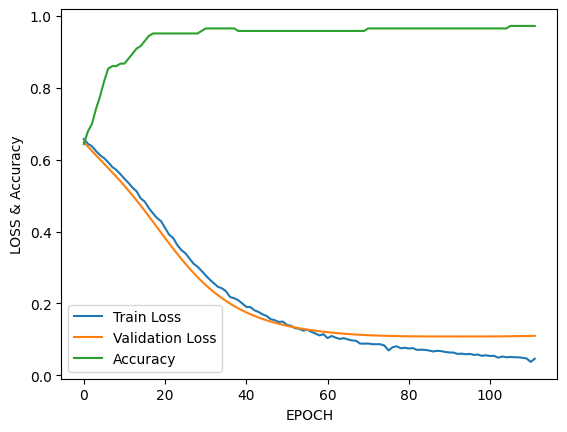

In [16]:
## train loss, valid loss 의 epoch 별 변화의 흐름 시각화.
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.plot(val_accuracy_list, label="Accuracy")

plt.xlabel("EPOCH")
plt.ylabel("LOSS & Accuracy")
plt.legend()
plt.show()

# Model Evaluation

In [17]:
best_model = torch.load(save_bcmodel_path)
X_test_tensor.shape

torch.Size([143, 30])

In [18]:
pred_new = best_model(X_test_tensor)
pred_new.shape      # 각 1개의 예측값만 가지게 됨

torch.Size([143, 1])

In [19]:
pred_new[:5]    # positive(1)일 확률

tensor([[0.9945],
        [0.8484],
        [0.5526],
        [0.0433],
        [0.9997]], grad_fn=<SliceBackward0>)

In [20]:
# probability -> class index로 변환
pred_new_label = (pred_new > 0.5).type(torch.int32)
pred_new_label[:10]

tensor([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1]], dtype=torch.int32)

In [21]:
# pred_new_label 과 같은 index의 값이 동일하면 예측이 맞은 것! (이 경우, 모든 예측이 다 맞음)
y_test_tensor[:10]

tensor([[1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.]])